<h1>Environment set up</h1>
load packages and files

In [1]:
import tables
from goatools.semantic import resnik_sim
from goatools.semantic import lin_sim
from goatools.semantic import semantic_similarity
from goatools.semantic import deepest_common_ancestor
from goatools import obo_parser
from goatools.associations import read_gaf
from goatools.semantic import TermCounts, get_info_content

from pyoma.browser import db

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import random

In [2]:
# load all the files (oma database, go dag file, association gaf file)
# set oma database
# contains genes and related GO terms
omaDataLocation = "/home/laurent/Documents/ValidationGoTerms/GOterms/go/data/oma/OmaServer.h5"
h5file = tables.open_file(omaDataLocation, mode='r')

dbObj = db.Database(h5file)
omaIdObj = db.OmaIdMapper(dbObj)

#load gene ontology DAG
#use guaranteed acyclic basic GO
go = obo_parser.GODag('/home/laurent/Documents/ValidationGoTerms/GOterms/go/data/onto/go.obo')

associations = read_gaf('/home/laurent/Downloads/GOterms/gene_association.tair.gz')
#associations = read_gaf("http://geneontology.org/gene-associations/gene_association.tair.gz")

# First get the counts of each GO term.
termcounts = TermCounts(go, associations)

/home/laurent/anaconda3/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/Protein/_i_Entries/OmaHOG/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


load obo file /home/laurent/Documents/ValidationGoTerms/GOterms/go/data/onto/go.obo
/home/laurent/Documents/ValidationGoTerms/GOterms/go/data/onto/go.obo: fmt(1.2) rel(2017-02-07) 46,248 GO Terms
  READ 217,451 associations: /home/laurent/Downloads/GOterms/gene_association.tair.gz
53 Assc. GO IDs not found in the GODag



<h1>Create fake pipeline results</h1>
take random hogs from the dataset to test the validation part

In [3]:
# Get list of Hogs; working dataset

# get all the hogs from vertebrata
vertebratesHogsList = []
for hog in dbObj.get_hdf5_handle().get_node('/HogLevel').where('Level == b"Vertebrata"'):
    vertebratesHogsList.append(hog[1])

/home/laurent/anaconda3/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/_i_HogLevel/ID/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
/home/laurent/anaconda3/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/_i_HogLevel/Level/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in c

In [4]:
# as very slow to keep only the biggest one, do it only on the first 1000
# TODO do it on all ... 
tempList = vertebratesHogsList[0:1000]

In [5]:
from multiprocessing import Pool

def addHogIfSize(hogs):
    
    newList = []
    for hog in hogs:
        if(len(dbObj.hog_members_from_hog_id(hog,"Vertebrata")) >= 3):
            newList.append(hog)
            
    return newList


# this part doesnt work ... 
def keepHogMinSize(hogsList):
    
    hogsSize = []
    
    chunks = [hogsList[i::4] for i in range(4)]
    pool = Pool(processes=4)
    
    lists = pool.map(addHogIfSize, chunks)
    return lists

In [114]:
tempHogList = addHogIfSize(tempList)

In [133]:
def randomHogs(hogList, m=random.randint(5,9)):
    return random.sample(hogList, m)

def randomResults(hogList, qHog, nr_rHog):
    rHogList = []
    
    for i in range(nr_rHog):
        
        indexToChange = random.sample(range(len(qHog)),random.randint(1,len(qHog)))
        for i in indexToChange:
            qHog[i] = random.sample(hogList,1)[0]
        
        rHogList.append(qHog)
        
    return rHogList

In [134]:
qHog = randomHogs(tempHogList)
rHogs = randomResults(tempHogList, qHog, 10)

<h1>Get GO terms</h1>

In [9]:
# decode hog format
def _hog_lex_range( hog):
    hog_str = hog.decode() if isinstance(hog, bytes) else hog
    return hog_str.encode('ascii'), (hog_str[0:-1] + chr(1 + ord(hog_str[-1]))).encode('ascii')

# yield hog members given hog id and oma database
def iterHOGMembers(odb,hog_id):
    hog_range = _hog_lex_range(hog_id)
    it = odb.root.Protein.Entries.where( '({!r} <= OmaHOG) & (OmaHOG < {!r})'.format(*hog_range))
    for row in it:
        yield row.fetch_all_fields()

# returns go terms
def grabGOterms(odb, hog_id, maxEntries = 5000):
    iterator = iterHOGMembers(odb, hog_id)
   
    if maxEntries == None:
        population = frozenset( [x['EntryNr'] for x in iterator] )
    else:
        population = []
        for i,x in enumerate(iterator):
            if i > maxEntries:
                break
            population.append(x['EntryNr'])
        population = frozenset(population)
    
    #turn into godict
    godict = {entry: {('GO:{:07d}'.format(e['TermNr']),  # Make the GO:0000001 style ID again (GOATOOLS requires this)
                   #str(e['Evidence'].decode('utf-8')),      # Extract Evidence code
                   #str(e['Reference'].decode('utf-8'))
                      )     # Extract Reference code
                  for e in odb.root.Annotations.GeneOntology.read_where('EntryNr == {}'.format(entry))   } for entry in population}
    cpt = sum([1 for a in godict.values() if a == set()])    
    return godict, cpt


# def getProtEntry(odb, entry_nr):
#     entry = odb.root.Protein.Entries.read_where('EntryNr == {}'.format(entry_nr))
#     if len(entry) != 1:
#         raise ValueError("there are {} entries with entry_nr {}".format(len(entry), entry_nr))
#     entry = entry[0]
#     return entry

# def getProtEntryFromCanonical(odb, CanonicalId):
#     #doesnt work yet
    
#     entry = odb.root.Protein.Entries.read_where('CanonicalId == {}'.format(CanonicalId) )
#     if len(entry) != 1:
#         raise ValueError("there are {} entries with CanonicalId {}".format(len(entry), CanonicalId))
#     entry = entry[0]
#     return entry

# # get sequence of hog
# def grabSequences(odb, hog_id):
#     iterator = iterHOGMembers(odb, hog_id)
#     #grab all oma IDs
#     seqArr = odb.get_node('/Protein/SequenceBuffer')
#     seqdict={}
#     for x in iterator:
#         if x['EntryNr'] not in seqdict:
#             entry = getProtEntry(odb,x['EntryNr'])
#             seqdict[x['EntryNr']] = seqArr[entry['SeqBufferOffset']:entry['SeqBufferOffset'] + entry['SeqBufferLength'] - 1].tostring()
#     return seqdict


In [145]:
qhog = 'HOG:0385023'
qhog = 'HOG:0276743'
godict, cpt= grabGOterms(h5file,qhog)
#seqdict = grabSequences(h5file, qhog)
print(godict)
print(len(godict))

#deepest_common_ancestor(['GO:0044770','GO:0044772'],go)


{7067131: set(), 7152283: set(), 8196563: set()}
3


In [41]:
# semantic similarity measures

def resnik(annot1, annot2):
    #calculate the max GO similarity with two metrics
    maxresnik = 0
    for gotuple1 in annot1:
        for gotuple2 in annot2:

             resnik = resnik_sim(goterm1, goterm2, go, termcounts)

            if resnik>maxresnik:
                maxresnik = resnik
            
             #passOKannotations = ['EXP', 'IMP', 'IGI', 'IPI', 'IEP', 'IDA']
                    
    return maxresnik

def lin(annot1, annot2):
    #calculate the max GO similarity with two metrics
    maxresnik = 0
    for gotuple1 in annot1:
        for gotuple2 in annot2:
            goterm1,evid1,omacode1 = gotuple1
            goterm2,evid2,omacode2 = gotuple2
            lin = lin_sim(goterm1, goterm2, go, termcounts)
            if lin != None and -lin>maxresnik:
                maxresnik = -lin
    return  maxresnik

def GOdist(godict1,godict2, semfunction):
    
    go1 = godict1
    go2 = godict2
    resnikMat = np.zeros( ( len(godict1) , len(godict2) ) ) 

    godists={}
    for j,key2 in enumerate(go2.keys()):
        for i,key1 in enumerate(go1.keys()):
            l1 = go1[key1]
            l2 = go2[key2]
            dist = semfunction(l1,l2)
            resnikMat[i,j]= dist
    return resnikMat 
    

In [78]:
goterms1 = set([('GO:0005886', 'IEA', 'GO_REF:107'), ('GO:0048235', 'IEA', 'GO_REF:107'), ('GO:0005783', 'IEA', 'GO_REF:107'), ('GO:0016021', 'IEA', 'GO_REF:038'), ('GO:0016020', 'IEA', 'GO_REF:038')])
goterms2 = set([('GO:0016021', 'IEA', 'GO_REF:038'), ('GO:0016020', 'IEA', 'GO_REF:038')])
goterms3 = set([('GO:0005739', 'IEA', 'GO_REF:038'), ('GO:0070469', 'IEA', 'GO_REF:038'), ('GO:0016491', 'IEA', 'GO_REF:038'), ('GO:0008121', 'IEA', 'GO_REF:003'), ('GO:0005743', 'IEA', 'GO_REF:040'), ('GO:0016679', 'IEA', 'GO_REF:002'), ('GO:0022900', 'IEA', 'GO_REF:108'), ('GO:0016021', 'IEA', 'OMA_Fun:001'), ('GO:0051537', 'IEA', 'GO_REF:002'), ('GO:0008121', 'IEA', 'GO_REF:002')])
maxresnik = resnik(goterms1,goterms2)
print(maxresnik)
maxresnik = lin(goterms1,goterms2)
print(maxresnik)


4.015605215812262
1.0


In [38]:
#to deal with distance matrix between go term corpuses

def NonZeroAvg(resnikMat):
    #The average score between the annotation corpuses of two Hogs without counting proteins with no annotation
    
    indices = np.where(resnikMat > 0 )
    mean = np.mean(resnikMat[indices])
    if np.isnan(mean) == True:
        mean = 0 
    return mean

def retMax(resnikMat):
    #The max score between two corpuses of two hogs
    return np.amax(resnikMat)



HOG:0385023
{5906946: set(), 11009029: {('GO:0005739', 'IEA', 'GO_REF:038'), ('GO:0070469', 'IEA', 'GO_REF:038'), ('GO:0016491', 'IEA', 'GO_REF:038'), ('GO:0008121', 'IEA', 'GO_REF:003'), ('GO:0005743', 'IEA', 'GO_REF:040'), ('GO:0016679', 'IEA', 'GO_REF:002'), ('GO:0022900', 'IEA', 'GO_REF:108'), ('GO:0016021', 'IEA', 'OMA_Fun:001'), ('GO:0051537', 'IEA', 'GO_REF:002'), ('GO:0008121', 'IEA', 'GO_REF:002'), ('GO:0016020', 'IEA', 'GO_REF:002'), ('GO:0055114', 'IEA', 'GO_REF:002'), ('GO:0016491', 'IEA', 'GO_REF:002'), ('GO:0055114', 'IEA', 'GO_REF:038')}, 10375178: {('GO:0005739', 'IEA', 'GO_REF:038'), ('GO:0070469', 'IEA', 'GO_REF:038'), ('GO:0016021', 'IEA', 'GO_REF:038'), ('GO:0016491', 'IEA', 'GO_REF:038'), ('GO:0008121', 'IEA', 'GO_REF:003'), ('GO:0005743', 'IEA', 'GO_REF:040'), ('GO:0016679', 'IEA', 'GO_REF:002'), ('GO:0016491', 'IEA', 'GO_REF:002'), ('GO:0022900', 'IEA', 'GO_REF:108'), ('GO:0051537', 'IEA', 'GO_REF:002'), ('GO:0008121', 'IEA', 'GO_REF:002'), ('GO:0016020', 'IEA', 

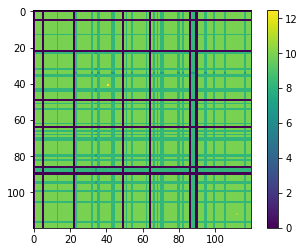

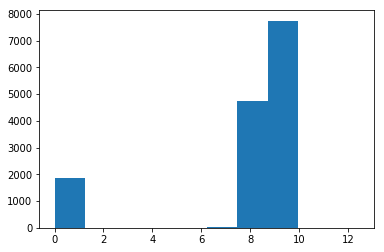

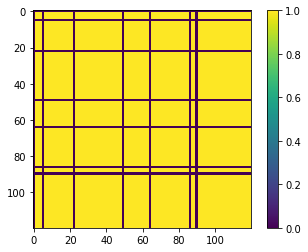

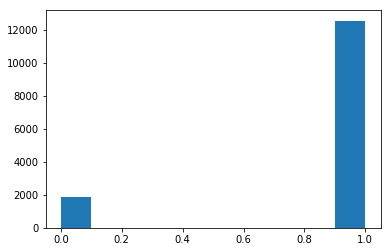

HOG:0374514
HOG:0385024


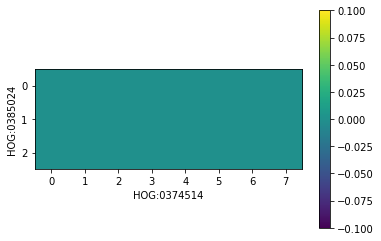

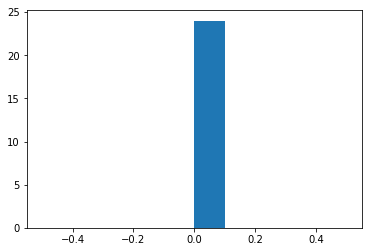

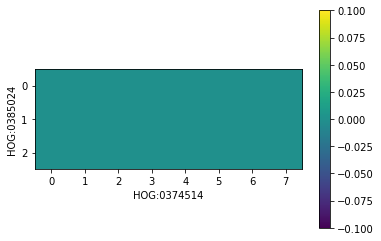

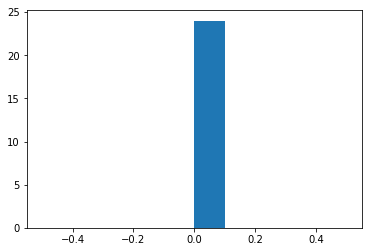

HOG:0374514
HOG:0262715


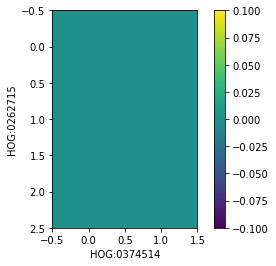

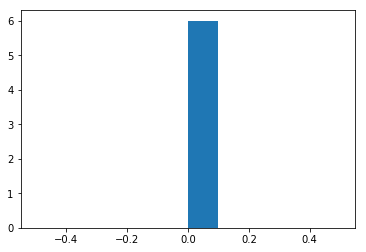

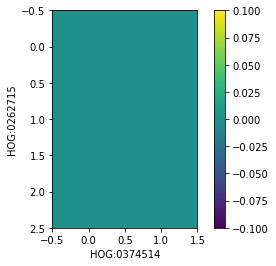

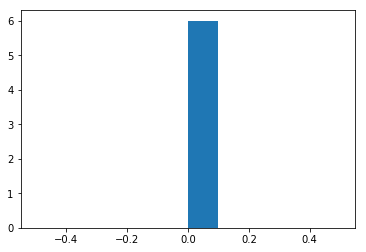

HOG:0385024
HOG:0262715


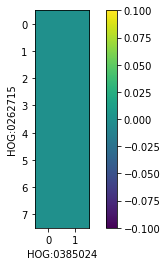

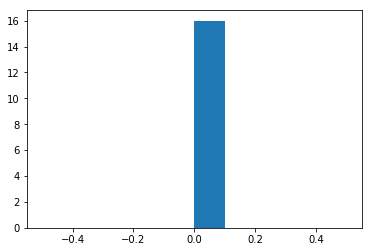

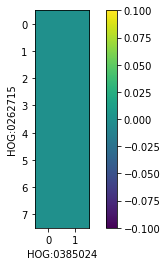

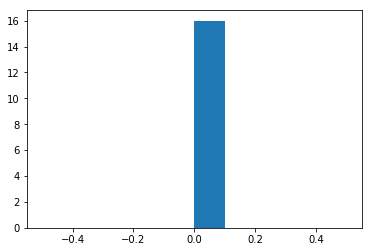

In [79]:
from itertools import combinations

for qhog in ['HOG:0385023']:

    print(qhog)
    #get a hog from a gene. useful for ppi and string stuff
    godict, cpt= grabGOterms(h5file,qhog)
    print(godict)
    seqdict = grabSequences(h5file, qhog)

    resnikMat = GOdist(godict,godict,resnik)

    plt.imshow(resnikMat)
    plt.colorbar()
    plt.show()

    plt.hist(resnikMat.flatten())
    plt.show()

    resnikMat = GOdist(godict,godict,lin)

    plt.imshow(resnikMat)
    plt.colorbar()
    plt.show()

    plt.hist(resnikMat.flatten())
    plt.show()


for qhog1, qhog2 in combinations(['HOG:0374514' , 'HOG:0385024', 'HOG:0262715'], 2):
    print(qhog1)
    print(qhog2)
    
    
    #get a hog from a gene. useful for ppi and string stuff
    godict1, cpt= grabGOterms(h5file,qhog1)
    seqdict2 = grabSequences(h5file, qhog1)
    godict2, cpt= grabGOterms(h5file,qhog2)
    seqdict2 = grabSequences(h5file, qhog2)
    resnikMat = GOdist(godict1,godict2,resnik)
    
    plt.imshow(resnikMat)
    plt.ylabel(qhog2)
    plt.xlabel(qhog1)
    plt.colorbar()
    plt.show()

    plt.hist(resnikMat.flatten())
    plt.show()

    resnikMat = GOdist(godict1,godict2,lin)

    plt.imshow(resnikMat)
    plt.ylabel(qhog2)
    plt.xlabel(qhog1)
    plt.colorbar()
    plt.show()

    plt.hist(resnikMat.flatten())
    plt.show()

<h1>1st method</h1>
<h2>for each gene of each hog, take all go terms and create a dictionary : keys = hog id, values = go terms. Compute all Resnik between them. compute mean of the go term, best mean, best go term for the Hog. We end up with one GO term per gene.</h2>

In [153]:
# query hogs --> qHog
# results hogs --> rHogs

In [164]:
def GetGoTermsByHogs(qHog):
    hogDict = {}
    for hog in qHog:
        godict = {}
        godict, cpt= grabGOterms(h5file,hog)
        godict = { k : v for k,v in godict.items() if v}
        goTermList = []
        for k, v in godict.items():
            for i in v:
                goTermList.append(i[0])
        if goTermList:        
            hogDict[hog.decode('utf-8')] = goTermList
    return hogDict

def GetGoTermsByListHogs(rHogs):
    listHogDict = []
    for hog in rHogs:
        listHogDict.append(GetGoTermsByHogs(hog))
        
    return listHogDict


In [165]:
goDictq = GetGoTermsByHogs(qHog)
goDictr = GetGoTermsByListHogs(rHogs)

In [166]:
print(goDictr)

[{'HOG:0276896': ['GO:0001919', 'GO:0032266', 'GO:0007173', 'GO:0080025', 'GO:0005871', 'GO:0008574', 'GO:0005524', 'GO:0032801', 'GO:0006895', 'GO:0007492', 'GO:0043325', 'GO:0008017', 'GO:0005547', 'GO:0007018', 'GO:0008543', 'GO:0001704', 'GO:0005769', 'GO:0045022', 'GO:0005829', 'GO:0005737', 'GO:0008574', 'GO:0003774', 'GO:0007492', 'GO:0008017', 'GO:0005856', 'GO:0008543', 'GO:0045022', 'GO:0016020', 'GO:0035091', 'GO:0032266', 'GO:0007173', 'GO:0005874', 'GO:0005871', 'GO:0005524', 'GO:0005547', 'GO:0003777', 'GO:0031901', 'GO:0032801', 'GO:0071346', 'GO:0017137', 'GO:0005769', 'GO:0001919', 'GO:0080025', 'GO:0045335', 'GO:0000166', 'GO:0006895', 'GO:0043325', 'GO:0007018', 'GO:0001704', 'GO:0008289', 'GO:0005768', 'GO:0005829', 'GO:0008574', 'GO:0003774', 'GO:0007492', 'GO:0008017', 'GO:0008543', 'GO:0016887', 'GO:0045022', 'GO:0035091', 'GO:0032266', 'GO:0007173', 'GO:0005871', 'GO:0005524', 'GO:0005547', 'GO:0003777', 'GO:0032801', 'GO:0071346', 'GO:0017137', 'GO:0005769', 'G

In [181]:
def BestGOByListHog(listGoDict):
    listDicRes = []
    for dic in listGoDict:
        listDicRes.append(BestGOByHog(dic))
    return listDicRes
        
def BestGOByHog(goDict):
    dictRes = {}
    for k,v in goDict.items():
        dictRes[k] = getBestGo(v)
    return dictRes

def getBestGo(listGoTerm):
    semMat = np.zeros((len(listGoTerm), len(listGoTerm)))
    
    go1 = go2 = listGoTerm

    
    for index1, value1 in enumerate(go1):
        for index2, value2 in enumerate(go2):
            dist = resnik_sim(value1, value2, go, termcounts)

            semMat[index1,index2]= dist
    semMat
    index, value = max(enumerate(semMat.mean(1)), key=operator.itemgetter(1))

    return listGoTerm[index]

######################

def CompareQueryResults(qHog, rHogs):
    compareRsults = []
    for r in rHogs:
        

def compareClusterHog(qHog, rHog):
    semMat = np.zeros((len(qHog), len(rHog)))
    
    for index1, value1 in enumerate(go1):
        for index2, value2 in enumerate(go2):
            dist = resnik_sim(value1, value2, go, termcounts)

            semMat[index1,index2]= dist
    semMat
    index, value = max(enumerate(semMat.mean(1)), key=operator.itemgetter(1))

    return resultValue

def NonZeroAvg(resnikMat):
    #The average score between the annotation corpuses of two Hogs without counting proteins with no annotation
    
    indices = np.where(resnikMat > 0 )
    mean = np.mean(resnikMat[indices])
    if np.isnan(mean) == True:
        mean = 0 
    return mean

def retMax(resnikMat):
    #The max score between two corpuses of two hogs
    return np.amax(resnikMat)


In [182]:
bestGOq = BestGOByHog(goDict)
bestGor = BestGOByListHog(goDictr)